# Model Training and Selection

## Poisson Regression

In [143]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

### Route 4, Direction 1, Bus Stop 12

In [144]:
Xdt_train = pd.read_csv('Data/xDT_train_board_x.csv')
Xdt_test = pd.read_csv('Data/xDT_test_board_x.csv')

In [145]:
Xdt_train.service_kind = Xdt_train['service_kind'].astype(str)
Xdt_train.month = Xdt_train['month'].astype(str)
Xdt_train.hour = Xdt_train['hour'].astype(str)

Xdt_test.service_kind = Xdt_test['service_kind'].astype(str)
Xdt_test.month = Xdt_test['month'].astype(str)
Xdt_test.hour = Xdt_test['hour'].astype(str)

In [116]:
expr = 'board_count ~ month + service_kind + hour + mean_temp + mean_precip + surrounding_board_count'
        
np.random.seed(123)
y_train, X_train = dmatrices(expr, Xdt_train, return_type = 'dataframe')
y_test, X_test = dmatrices(expr, Xdt_test, return_type = 'dataframe')
        
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
       
poisson_predictions = poisson_training_results.get_prediction(X_test)
poisson_predictions_summary_frame = poisson_predictions.summary_frame()

/opt/conda/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


In [117]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            board_count   No. Observations:                 3934
Model:                            GLM   Df Residuals:                     3901
Model Family:                 Poisson   Df Model:                           32
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2477.4
Date:                Thu, 22 Apr 2021   Deviance:                       3617.5
Time:                        16:57:10   Pearson chi2:                 8.72e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [118]:
poisson_predictions = poisson_training_results.predict(X_test)
poisson_predicted_counts = np.round(poisson_predictions)

actual_counts = y_test['board_count']
        
poisson_RMSE = np.sqrt(mean_squared_error(poisson_predicted_counts,actual_counts))
poisson_RMSE  

0.7548065564669268

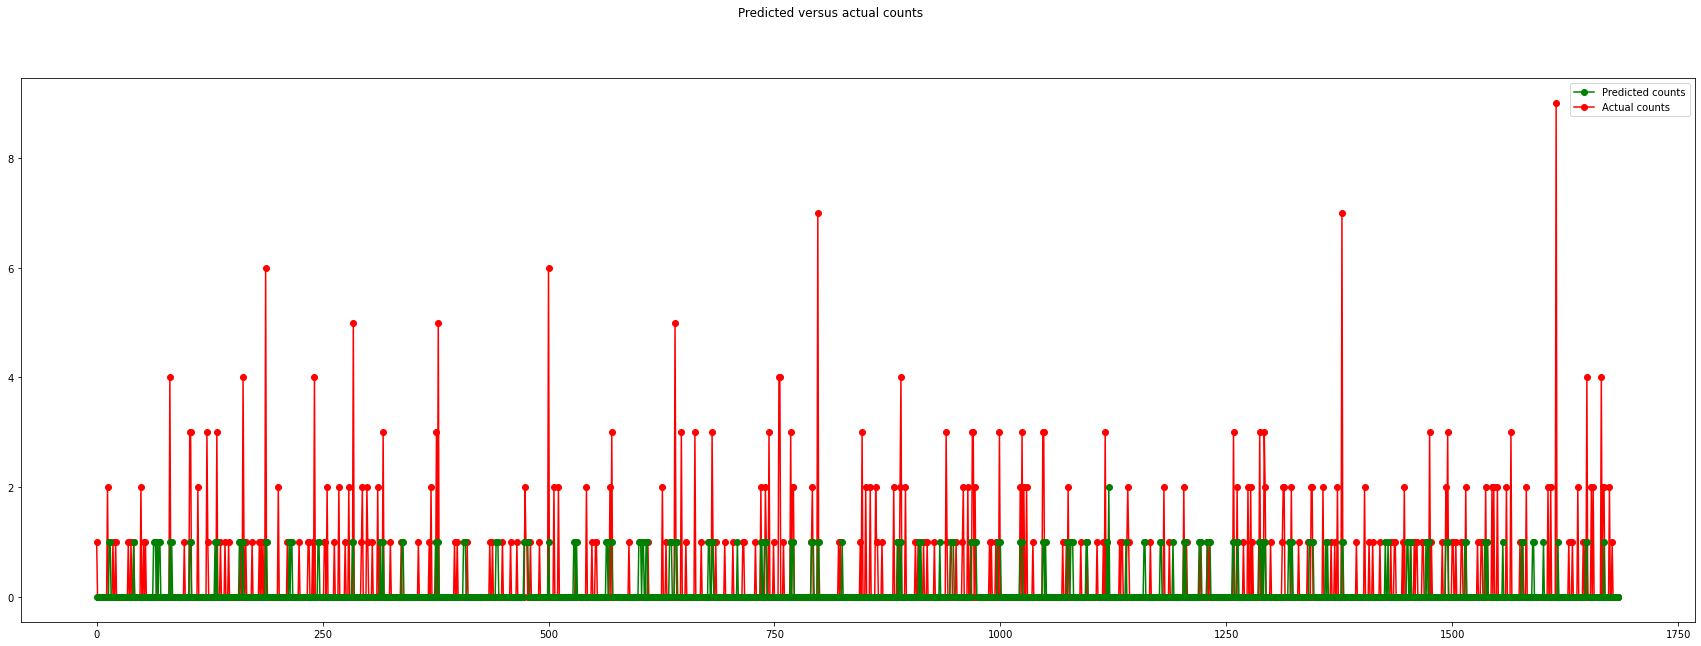

In [119]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 10))
fig.suptitle('Predicted versus actual counts')

actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(X_test.index, poisson_predicted_counts, 'go-', label='Predicted counts')

plt.legend(handles=[predicted, actual])
plt.show()

## Negative Binomial Regression

This section of the notebook is based on this [post](https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4), which proposes a *pipe-line* that starts with the data (rates: $\lambda$) obtained from an initial Poisson model apporach. These rates are then added as a covariate for the Negative Binomial model.

However, we also show how to train Negative Binomial models without using the proposed *pipe-line*.

### Negative Binomial Model

In [120]:
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [121]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial()).fit()
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            board_count   No. Observations:                 3934
Model:                            GLM   Df Residuals:                     3901
Model Family:        NegativeBinomial   Df Model:                           32
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2238.5
Date:                Thu, 22 Apr 2021   Deviance:                       2554.1
Time:                        16:57:24   Pearson chi2:                 6.89e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [122]:
nb2_predictions = nb2_training_results.predict(X_test)
nb2_predicted_counts = np.round(nb2_predictions)

actual_counts = y_test['board_count']
        
nb2_RMSE = np.sqrt(mean_squared_error(nb2_predicted_counts,actual_counts))
nb2_RMSE  

0.7532324013510729

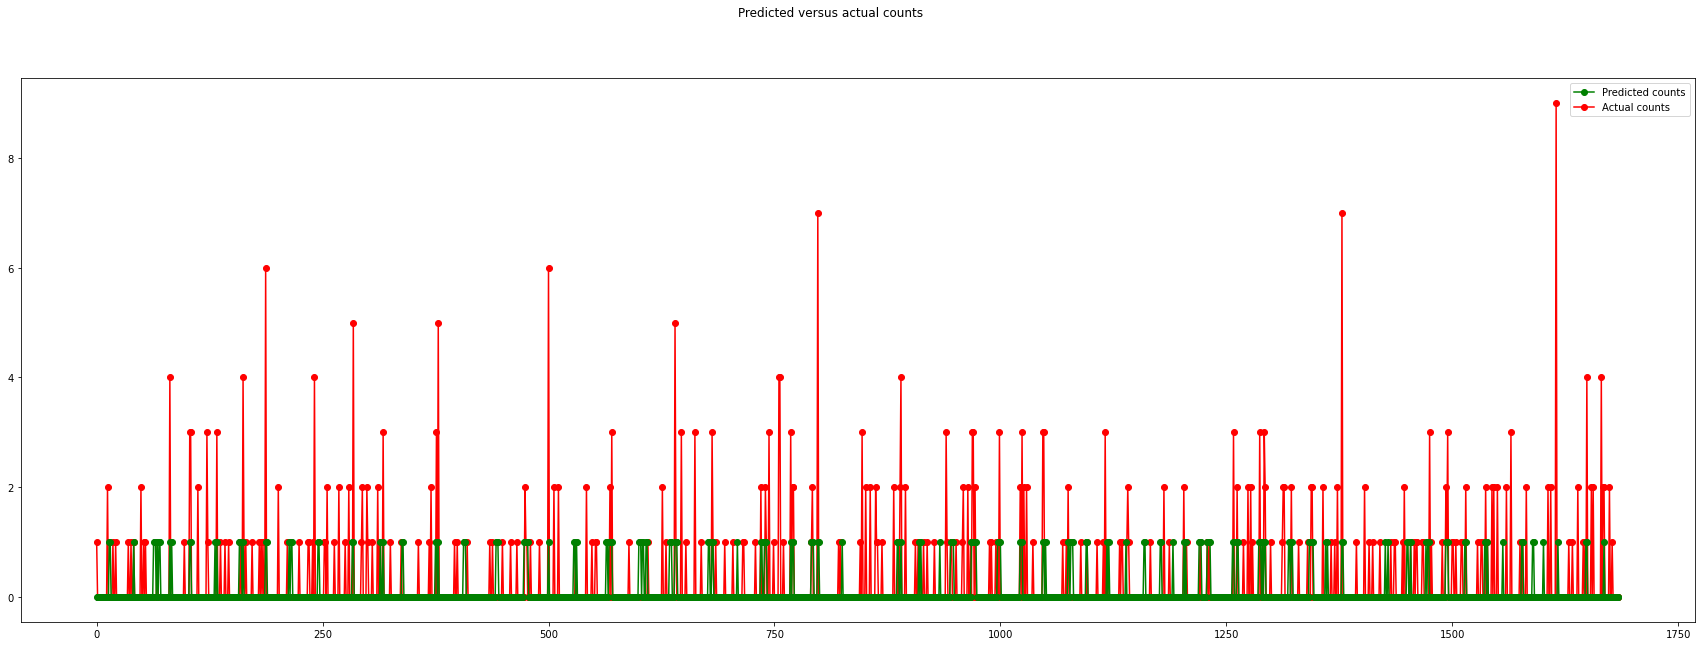

In [123]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 10))
fig.suptitle('Predicted versus actual counts')

actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(X_test.index, nb2_predicted_counts, 'go-', label='Predicted counts')

plt.legend(handles=[predicted, actual])
plt.show()

### Negative Binomial Model as part of a *Pipe-line*

#### Step 1: Fitting a Poisson Model

#### Step 2: Fitting the auxiliary OLS regression model on the data set and use the fitted model to get the value of $\alpha$

### Zero-Inflated Poisson

In [124]:
expr = 'board_count ~ month + service_kind + hour + mean_temp + mean_precip + surrounding_board_count'
        
np.random.seed(123)
y_train, X_train = dmatrices(expr, Xdt_train, return_type = 'dataframe')
y_test, X_test = dmatrices(expr, Xdt_test, return_type = 'dataframe')

In [156]:
Exog_Infl_train = X_train.iloc[:,12:29]
Exog_Infl_test = X_test.iloc[:,12:29]

inter_train = pd.DataFrame(np.repeat(1, X_train.shape[0]))
inter_train.columns = ['Intercept']

inter_test = pd.DataFrame(np.repeat(1, X_test.shape[0]))
inter_test.columns = ['Intercept']

exog_Infl_train = pd.concat([inter_train, Exog_Infl_train], axis = 1)
exog_Infl_test = pd.concat([inter_test, Exog_Infl_test], axis = 1)

In [157]:
zip_training_results = sm.ZeroInflatedPoisson(endog = y_train, exog = X_train, exog_infl = exog_Infl_train, inflation='logit', iterations = 100).fit()
print(zip_training_results.summary())

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.552076
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:             board_count   No. Observations:                 3541
Model:             ZeroInflatedPoisson   Df Residuals:                     3510
Method:                            MLE   Df Model:                           30
Date:                 Thu, 22 Apr 2021   Pseudo R-squ.:                 0.09355
Time:                         20:06:51   Log-Likelihood:                -1954.9
converged:                       False   LL-Null:                       -2156.6
Covariance Type:             nonrobust   LLR p-value:                 5.497e-67
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
inflate_Intercept       

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [127]:
zip_predictions = zip_training_results.predict(X_test, exog_infl = exog_Infl_test)
zip_predicted_counts = np.round(zip_predictions)
actual_counts = y_test['board_count']
zip_RMSE = np.sqrt(mean_squared_error(zip_predicted_counts, actual_counts))
zip_RMSE

0.7536262483852276

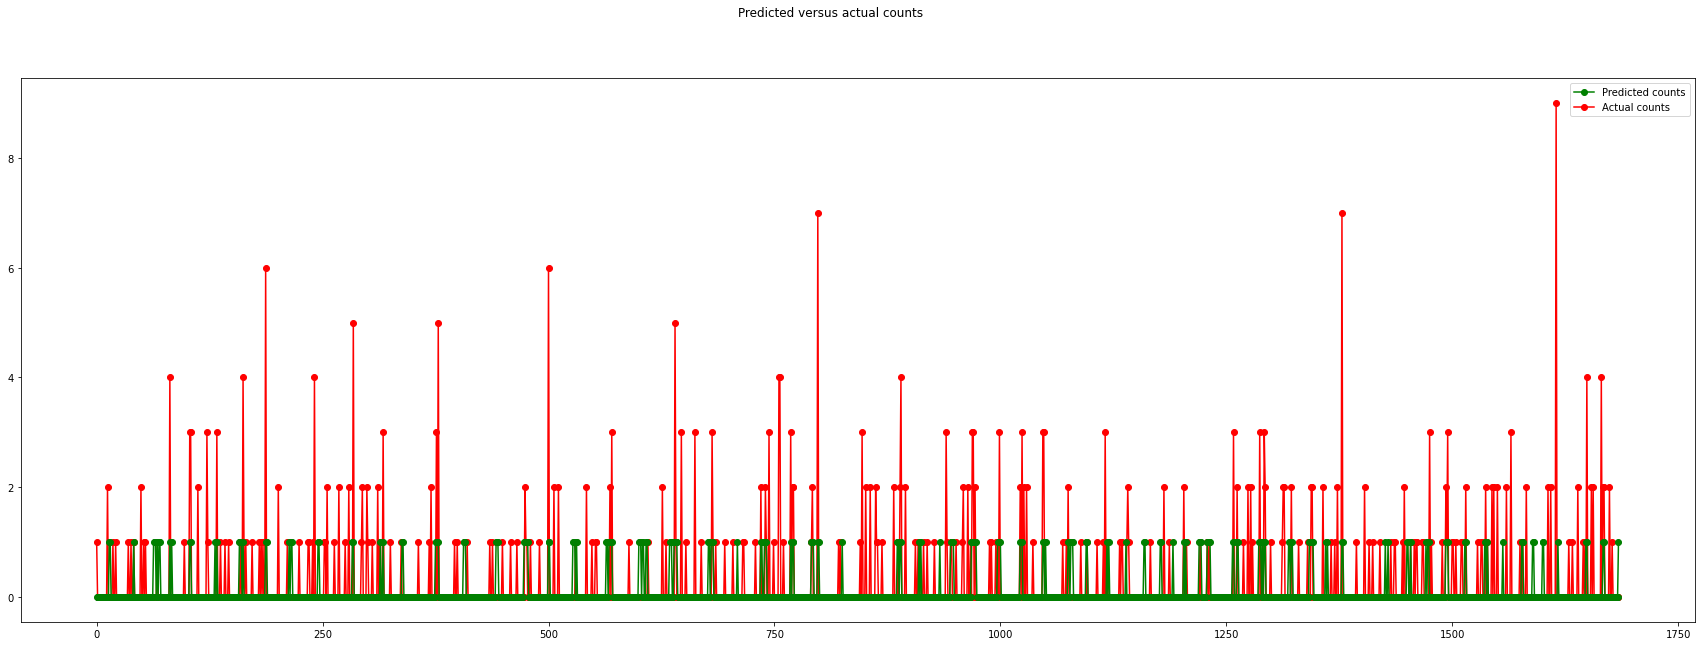

In [128]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 10))
fig.suptitle('Predicted versus actual counts')

actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(X_test.index, zip_predicted_counts, 'go-', label='Predicted counts')

plt.legend(handles=[predicted, actual])
plt.show()

### Zero-Inflated Negative Binomial

In [129]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [130]:
zinb2_training_results = sm.ZeroInflatedNegativeBinomialP(endog = y_train, exog = X_train, exog_infl = exog_Infl_train, inflation='logit', p = 2).fit()
print(zinb2_training_results.summary())

         Current function value: 0.548030
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                       board_count   No. Observations:                 3934
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3901
Method:                                      MLE   Df Model:                           32
Date:                           Thu, 22 Apr 2021   Pseudo R-squ.:                 0.06475
Time:                                   16:57:54   Log-Likelihood:                -2156.0
converged:                                 False   LL-Null:                       -2305.2
Covariance Type:                       nonrobust   LLR p-value:                 5.199e-45
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
inflate_Intercept                   -0.0557        nan        nan        nan  

In [131]:
zinb2_predictions = zinb2_training_results.predict(X_test, exog_infl = exog_Infl_test)
zinb2_predicted_counts = np.round(zinb2_predictions)
zinb2_RMSE = np.sqrt(mean_squared_error(zinb2_predicted_counts,actual_counts))
zinb2_RMSE

0.7536262483852276

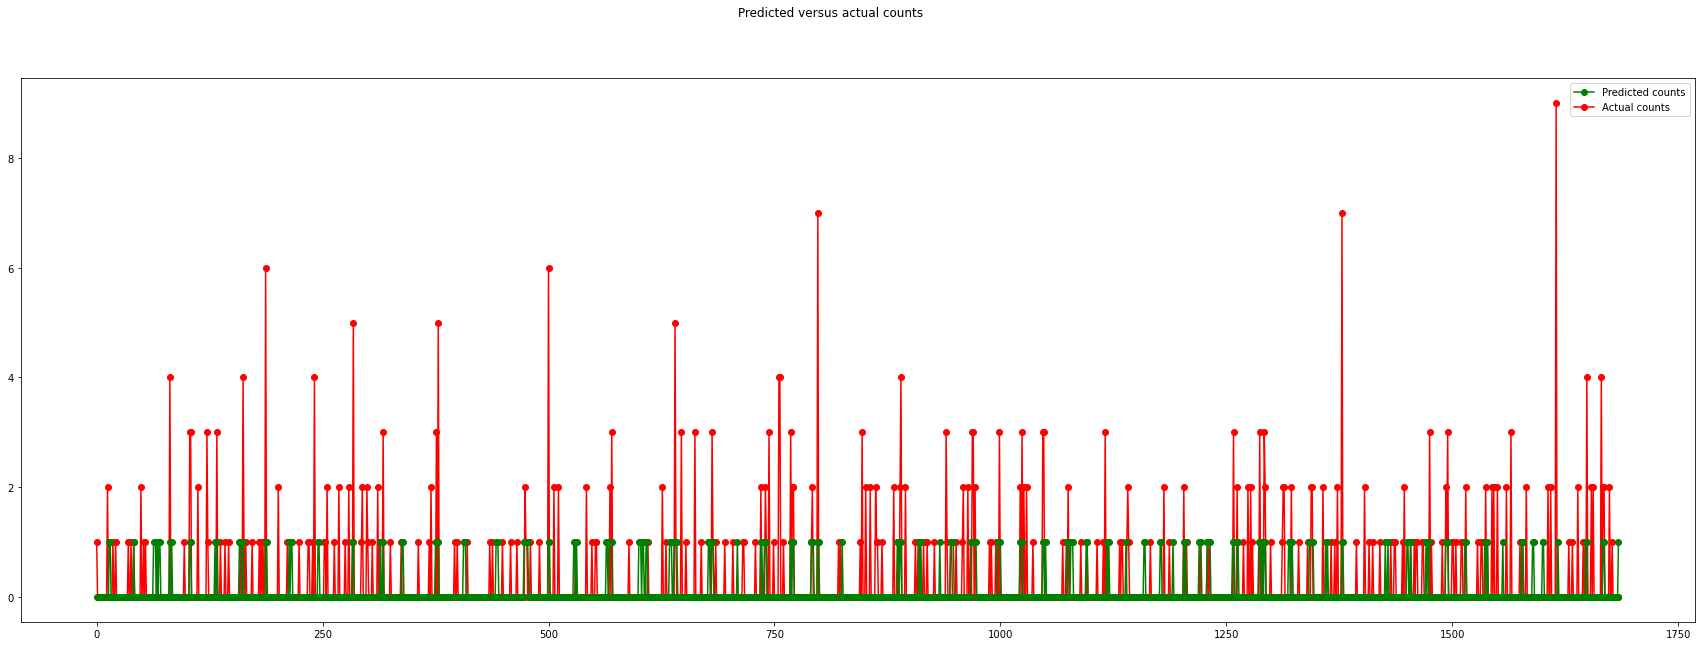

In [132]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 10))
fig.suptitle('Predicted versus actual counts')

actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
predicted, = plt.plot(X_test.index, zinb2_predicted_counts, 'go-', label='Predicted counts')

plt.legend(handles=[predicted, actual])
plt.show()

# CV for Train RMSE estimation

## Poisson Regression

In [133]:
from sklearn.model_selection import KFold

In [134]:
kf = KFold(n_splits = 10,  random_state = None, shuffle = False)
Poisson_RMSE = []

for train_index, test_index in kf.split(Xdt_train):
    y_train = y.iloc[train_index]
    X_train = X.loc[train_index, :]
    y_test = y.iloc[test_index]
    X_test = X.loc[test_index, :]
    poisson_training_results = sm.GLM(y_train, X_train, family = sm.families.Poisson()).fit()
    poisson_predictions = poisson_training_results.predict(X_test)
    poisson_predicted_counts = np.round(poisson_predictions)
    actual_counts = y_test['board_count']
    poisson_RMSE = np.sqrt(mean_squared_error(poisson_predicted_counts,actual_counts))
    Poisson_RMSE.append(poisson_RMSE)

In [135]:
Poisson_RMSE

[0.5939628592534965,
 0.7160239907502746,
 0.7265801963485438,
 0.9179540260321479,
 0.7616775379093997,
 0.9314958284241005,
 0.7991726001207218,
 0.6767682521924122,
 1.0652981042368306,
 0.8545641568769601]

## Negative Binomial

In [136]:
kf = KFold(n_splits = 10,  random_state = None, shuffle = False)
NB_RMSE = []

for train_index, test_index in kf.split(Xdt_train):
    y_train = y.iloc[train_index]
    X_train = X.loc[train_index, :]
    y_test = y.iloc[test_index]
    X_test = X.loc[test_index, :]
    nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial()).fit()
    nb_predictions = nb_training_results.predict(X_test)
    nb_predicted_counts = np.round(nb_predictions)
    actual_counts = y_test['board_count']
    nb_RMSE = np.sqrt(mean_squared_error(nb_predicted_counts, actual_counts))
    NB_RMSE.append(nb_RMSE)

In [137]:
NB_RMSE

[0.5896742626574515,
 0.7160239907502746,
 0.7265801963485438,
 0.9179540260321479,
 0.6577005204154147,
 0.9135675114431208,
 0.7991726001207218,
 0.6842465814484706,
 1.081888839280541,
 0.8590189089915827]

## Zero-Inflated Poisson

In [152]:
kf = KFold(n_splits = 10,  random_state = None, shuffle = False)
ZIP_RMSE = []

for train_index, test_index in kf.split(Xdt_train):
    
    y_train = y.iloc[train_index]
    X_train = X.loc[train_index, :]
    y_test = y.iloc[test_index]
    X_test = X.loc[test_index, :]
    
    actual_counts = y_test['board_count']
    
    Exog_Infl_train = pd.DataFrame(X_train.iloc[:,12:29])
    Exog_Infl_test = pd.DataFrame(X_test.iloc[:,12:29])
    
    Exog_Infl_train['Intercept'] = np.repeat(1, Exog_Infl_train.shape[0])
    Exog_Infl_test['Intercept'] = np.repeat(1, Exog_Infl_test.shape[0])
        
    zip_training_results = sm.ZeroInflatedPoisson(endog = y_train, exog = X_train, exog_infl = Exog_Infl_train, inflation='logit').fit()
    zip_predicted_counts = np.round(zip_training_results.predict(X_test, exog_infl = Exog_Infl_test))
    zip_RMSE = np.sqrt(mean_squared_error(zip_predicted_counts, actual_counts))
    ZIP_RMSE.append(zip_RMSE)

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.555745
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.560193
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.553343
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.561067
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.560387
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.544841
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.556509
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.563247
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.543731
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.552076
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [153]:
ZIP_RMSE

[0.5918224455920872,
 0.7213214044570692,
 0.7300650134459725,
 1.0113568309918655,
 0.819607055356919,
 0.8795094630953667,
 0.7895629608911476,
 0.6420387375057796,
 1.081888839280541,
 0.8545641568769601]

## Zero-Inflated Negative Binomial

In [141]:
kf = KFold(n_splits = 10,  random_state = None, shuffle = False)
ZINB_RMSE = []

for train_index, test_index in kf.split(Xdt_train):
    
    y_train = y.iloc[train_index]
    X_train = X.loc[train_index, :]
    y_test = y.iloc[test_index]
    X_test = X.loc[test_index, :]
    
    actual_counts = y_test['board_count']
    
    Exog_Infl_train = pd.DataFrame(X_train.iloc[:,12:29])
    Exog_Infl_test = pd.DataFrame(X_test.iloc[:,12:29])
    
    Exog_Infl_train['Intercept'] = np.repeat(1, Exog_Infl_train.shape[0])
    Exog_Infl_test['Intercept'] = np.repeat(1, Exog_Infl_test.shape[0])
        
#    zinb_training_results = sm.ZeroInflatedNegativeBinomialP(endog = y_train, exog = X_train, exog_infl = Exog_Infl_train, inflation='logit').fit()
#    zinb_predicted_counts = np.round(zinb_training_results.predict(X_test, exog_infl = Exog_Infl_test))
#    zinb_RMSE = np.sqrt(mean_squared_error(zinb_predicted_counts, actual_counts))
#    ZINB_RMSE.append(zinb_RMSE)

### Function for CV:

In [140]:
kf = KFold(n_splits = 10,  random_state = None, shuffle = False)

y, X = dmatrices(expr, Xdt_train, return_type = 'dataframe')

Poisson_RMSE = []
NB_RMSE = []
ZIP_RMSE = []
ZINB_RMSE = []

for train_index, test_index in kf.split(Xdt_train):
    y_train = y.iloc[train_index]
    X_train = X.loc[train_index, :]
    y_test = y.iloc[test_index]
    X_test = X.loc[test_index, :]
    
    actual_counts = y_test['board_count']
    
    Exog_Infl_train = pd.DataFrame(X_train.iloc[:,12:29])
    Exog_Infl_test = pd.DataFrame(X_test.iloc[:,12:29])
    
    Exog_Infl_train['Intercept'] = np.repeat(1, Exog_Infl_train.shape[0])
    Exog_Infl_test['Intercept'] = np.repeat(1, Exog_Infl_test.shape[0])
    
    poisson_training_results = sm.GLM(y_train, X_train, family = sm.families.Poisson()).fit()
    nb_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial()).fit()
    zip_training_results = sm.ZeroInflatedPoisson(endog = y_train, exog = X_train, exog_infl = Exog_Infl_train, inflation='logit').fit()
#    zinb_training_results = sm.ZeroInflatedNegativeBinomialP(endog = y_train, exog = X_train, exog_infl = Exog_Infl_train, inflation='logit', p = 2).fit()
    
    poisson_predicted_counts = np.round(poisson_training_results.predict(X_test))
    nb2_predicted_counts = np.round(nb2_training_results.predict(X_test))
    zip_predicted_counts = np.round(zip_training_results.predict(X_test, exog_infl = Exog_Infl_test))
#    zinb_predicted_counts = np.round(zinb_training_results.predict(X_test, exog_infl = Exog_Infl_test))
    
    poisson_RMSE = np.sqrt(mean_squared_error(poisson_predicted_counts, actual_counts))
    nb_RMSE = np.sqrt(mean_squared_error(nb_predicted_counts, actual_counts))
    zip_RMSE = np.sqrt(mean_squared_error(zip_predicted_counts, actual_counts))
#    zinb_RMSE = np.sqrt(mean_squared_error(zinb_predicted_counts, actual_counts))
    
    Poisson_RMSE.append(poisson_RMSE)
    NB_RMSE.append(nb_RMSE)
    ZIP_RMSE.append(zip_RMSE)
#    ZINB_RMSE.append(zinb_RMSE)

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.555745
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37


/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: Found input variables with inconsistent numbers of samples: [393, 394]

In [154]:
def model_trainig(Xdt_train):
    
    import numpy as np
    import pandas as pd
    from patsy import dmatrices
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits = 10,  random_state = None, shuffle = False)

    y, X = dmatrices(expr, Xdt_train, return_type = 'dataframe')

    Poisson_RMSE = []
    NB_RMSE = []
    ZIP_RMSE = []
    ZINB_RMSE = []

    for train_index, test_index in kf.split(Xdt_train):
        y_train = y.iloc[train_index]
        X_train = X.loc[train_index, :]
        y_test = y.iloc[test_index]
        X_test = X.loc[test_index, :]
    
        actual_counts = y_test['board_count']
    
        Exog_Infl_train = pd.DataFrame(X_train.iloc[:,12:29])
        Exog_Infl_test = pd.DataFrame(X_test.iloc[:,12:29])
    
        Exog_Infl_train['Intercept'] = np.repeat(1, Exog_Infl_train.shape[0])
        Exog_Infl_test['Intercept'] = np.repeat(1, Exog_Infl_test.shape[0])
    
        poisson_training_results = sm.GLM(y_train, X_train, family = sm.families.Poisson()).fit()
        nb_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial()).fit()
        zip_training_results = sm.ZeroInflatedPoisson(endog = y_train, exog = X_train, exog_infl = Exog_Infl_train, inflation='logit').fit()
        zinb_training_results = sm.ZeroInflatedNegativeBinomialP(endog = y_train, exog = X_train, exog_infl = Exog_Infl_train, inflation='logit', p = 2).fit()
    
        poisson_predicted_counts = np.roun(poisson_training_results.predict(X_test))
        nb2_predicted_counts = np.round(nb2_training_results.predict(X_test))
        zip_predicted_counts = np.round(zip_training_results.predict(X_test, exog_infl = Exog_Infl_test))
        zinb_predicted_counts = np.round(zinb_training_results.predict(X_test, exog_infl = Exog_Infl_test))
    
        poisson_RMSE = np.sqrt(mean_squared_error(poisson_predicted_counts, actual_counts))
        nb_RMSE = np.sqrt(mean_squared_error(nb_predicted_counts, actual_counts))
        zip_RMSE = np.sqrt(mean_squared_error(zip_predicted_counts, actual_counts))
        zinb_RMSE = np.sqrt(mean_squared_error(zinb_predicted_counts, actual_counts))
    
        Poisson_RMSE.append(poisson_RMSE)
        NB_RMSE.append(nb_RMSE)
        ZIP_RMSE.append(zip_RMSE)
        ZINB_RMSE.append(zinb_RMSE)
        
        Avg_Poisson_RMSE = np.mean(Poisso_RMSE)
        Avg_NB_RMSE = np.mean(NB_RMSE)
        Avg_ZIP_RMSE = np.mean(ZIP_RMSE)
        Avg_ZINB_RMSE = np.mean(ZINB_RMSE)

In [155]:
model_training(Xdt_train)

NameError: name 'model_training' is not defined

In [ ]:
### Hurdle Poisson-Binomial

In [25]:
from typing import Optional, Union
import numpy as np
import pandas as pd

In [26]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.base import BaseEstimator
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from lightgbm import LGBMClassifier, LGBMRegressor

In [148]:
class HurdleRegression(BaseEstimator):
    """ Regression model which handles excessive zeros by fitting a two-part model and combining predictions:
            1) binary classifier
            2) continuous regression
    Implementeted as a valid sklearn estimator, so it can be used in pipelines and GridSearch objects.
    Args:
        clf_name: currently supports either 'logistic' or 'LGBMClassifier'
        reg_name: currently supports either 'linear' or 'LGBMRegressor'
        clf_params: dict of parameters to pass to classifier sub-model when initialized
        reg_params: dict of parameters to pass to regression sub-model when initialized
    """

    def __init__(self,
                 clf_name: str = 'logistic',
                 reg_name: str = 'linear',
                 clf_params: Optional[dict] = None,
                 reg_params: Optional[dict] = None):

        self.clf_name = clf_name
        self.reg_name = reg_name
        self.clf_params = clf_params
        self.reg_params = reg_params

    @staticmethod
    def _resolve_estimator(func_name: str):
        """ Lookup table for supported estimators.
        This is necessary because sklearn estimator default arguments
        must pass equality test, and instantiated sub-estimators are not equal. """

        funcs = {'linear': LinearRegression(),
                 'logistic': LogisticRegression(solver='liblinear'),
                 'LGBMRegressor': LGBMRegressor(n_estimators=50),
                 'LGBMClassifier': LGBMClassifier(n_estimators=50)}

        return funcs[func_name]

    def fit(self,
            X: Union[np.ndarray, pd.DataFrame],
            y: Union[np.ndarray, pd.Series]):
        X, y = check_X_y(X, y, dtype=None,
                         accept_sparse=False,
                         accept_large_sparse=False,
                         force_all_finite='allow-nan')

        if X.shape[1] < 2:
            raise ValueError('Cannot fit model when n_features = 1')

        self.clf_ = self._resolve_estimator(self.clf_name)
        if self.clf_params:
            self.clf_.set_params(**self.clf_params)
        self.clf_.fit(X, y > 0)

        self.reg_ = self._resolve_estimator(self.reg_name)
        if self.reg_params:
            self.reg_.set_params(**self.reg_params)
        self.reg_.fit(X[y > 0], y[y > 0])

        self.is_fitted_ = True
        return self

    def predict(self, X: Union[np.ndarray, pd.DataFrame]):
        """ Predict combined response using binary classification outcome """
        X = check_array(X, accept_sparse=False, accept_large_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        return self.clf_.predict(X) * self.reg_.predict(X)

    def predict_expected_value(self, X: Union[np.ndarray, pd.DataFrame]):
        """ Predict combined response using probabilistic classification outcome """
        X = check_array(X, accept_sparse=False, accept_large_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        return self.clf_.predict_proba(X)[:, 1] * self.reg_.predict(X)


def manual_test():
    """ Validate estimator using sklearn's provided utility and ensure it can fit and predict on fake dataset. """
 #   check_estimator(HurdleRegression)
    from sklearn.datasets import make_regression
    X, y = make_regression()
    reg = HurdleRegression()
    reg.fit(X, y)
    reg.predict(X)


if __name__ == '__main__':
    manual_test()

In [149]:
 HurdleRegression(Xdt_train)

HurdleRegression(clf_name=      board_count month service_kind hour  mean_temp  mean_precip  \
0               0     1      weekday    9   0.065536     0.009611   
1               0     1      weekday    9   0.065536     0.009611   
2               0     1      weekday   13   0.211614     0.011898   
3               0     1      weekday   14   0.226468     0.020642   
4               1     1      weekday   15   0.198916     0.017472   
...           ...   ...          ...  ...        ...          ...   
3929            0     5     weekdend   15   0.784785     0.014189   
3930            0     5     weekdend   16   0.789672     0.000000   
3931            4     5     weekdend   18   0.761818     0.000000   
3932            0     5     weekdend   19   0.702016     0.001542   
3933            0     5     weekdend   19   0.702016     0.001542   

      surrounding_board_count  
0                    0.574958  
1                    0.574958  
2                    0.753866  
3                

## 

In [ ]:
def model_fit(DT_train, DT_test, dependent):
    
    import numpy as np
    from patsy import dmatrices
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    #statsmodels.genmod.families.family.NegativeBinomial
    import matplotlib.pyplot as plt
    
    if (dependent == 'board_count'):
        
        expr = 'board_count ~ month + service_kind + hour + mean_temp + mean_precip + surrounding_board_count'
        
        np.random.seed(123)
        y_train, X_train = dmatrices(expr, DT_train, return_type = 'dataframe')
        y_test, X_test = dmatrices(expr, DT_test, return_type = 'dataframe')
        
        poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
        
        nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial()).fit()
        
        zip_training_results = sm.ZeroInflatedPoisson(endog = y_train, exog = X_train, exog_infl = X_train.iloc[:,12:29], inflation='logit').fit()
        
        zinb2_training_results = sm.ZeroInflatedNegativeBinomialP(endog = y_train, exog = X_train, exog_infl = X_train.iloc[:,12:29], inflation='logit', p = 2).fit()
        
        #print(zip_training_results.summary())
        
        poisson_predictions = poisson_training_results.get_prediction(X_test)
        poisson_predicted_counts = np.round(poisson_predictions)
        
        nb2_predictions = nb2_training_results.get_prediction(X_test)
        nb2_predicted_counts = np.round(nb2_predictions)
        
        zip_predictions = zip_training_results.predict(X_test, exog_infl = X_test.iloc[:,12:29])
        zip_predicted_counts = np.round(zip_predictions)
        
        zinb2_predictions = zinb2_training_results.predict(X_test, exog_infl = X_test.iloc[:,12:29])
        zinb2_predicted_counts = np.round(zinb2_predictions)
                        
        actual_counts = y_test['board_count']
        
        poisson_RMSE = np.sqrt(np.sum(np.power(np.subtract(poisson_predicted_counts,actual_counts),2)))
        nb2_RMSE = np.sqrt(np.sum(np.power(np.subtract(nb2_predicted_counts,actual_counts),2)))
        zip_RMSE = np.sqrt(np.sum(np.power(np.subtract(zip_predicted_counts,actual_counts),2)))
        zinb2_RMSE = np.sqrt(np.sum(np.power(np.subtract(zinb2_predicted_counts,actual_counts),2)))
        
        #return(poisson_RMSE)
        #print('ZIP RMSE='+str(np.sqrt(np.sum(np.power(np.subtract(predicted_counts,actual_counts),2)))))
        
        
        
    elif (dependent == 'alight_count'):
        
        expr = 'alight_count ~ month + service_kind + hour + mean_temp + mean_precip + surrounding_alight_count'
        
        np.random.seed(123)
        y_train, X_train = dmatrices(expr, DT_train, return_type = 'dataframe')
        y_test, X_test = dmatrices(expr, DT_test, return_type = 'dataframe')
        
        poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
        
        nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial()).fit()
        
        zip_training_results = sm.ZeroInflatedPoisson(endog = y_train, exog = X_train, exog_infl = X_train.iloc[:,12:29], inflation='logit').fit()
        
        zinb2_training_results = sm.ZeroInflatedNegativeBinomialP(endog = y_train, exog = X_train, exog_infl = X_train.iloc[:,12:29], inflation='logit', p = 2).fit()
        
        #print(zip_training_results.summary())
        
        poisson_predictions = poisson_training_results.get_prediction(X_test)
        poisson_predicted_counts = np.round(poisson_predictions)
        
        nb2_predictions = nb2_training_results.get_prediction(X_test)
        nb2_predicted_counts = np.round(nb2_predictions)
        
        zip_predictions = zip_training_results.predict(X_test, exog_infl = X_test.iloc[:,12:29])
        zip_predicted_counts = np.round(zip_predictions)
        
        zinb2_predictions = zinb2_training_results.predict(X_test, exog_infl = X_test.iloc[:,12:29])
        zinb2_predicted_counts = np.round(zinb2_predictions)
                        
        actual_counts = y_test['alight_count']
        
        poisson_RMSE = np.sqrt(np.sum(np.power(np.subtract(poisson_predicted_counts,actual_counts),2)))
        nb2_RMSE = np.sqrt(np.sum(np.power(np.subtract(nb2_predicted_counts,actual_counts),2)))
        zip_RMSE = np.sqrt(np.sum(np.power(np.subtract(zip_predicted_counts,actual_counts),2)))
        zinb2_RMSE = np.sqrt(np.sum(np.power(np.subtract(zinb2_predicted_counts,actual_counts),2)))
        
        
        